In [1]:
import torch
import time

import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import dlc_practical_prologue as prologue

In [2]:
!python3 dlc_practical_prologue.py

# Backpropagation

##  Activation function

In [3]:
def sigma(x):
    x = torch.tanh(x)
    return x

def dsigma(b):
    y = sigma(b)
    c = 1 - y.pow(2)
    return c

##  Loss function

In [4]:
def loss(v,t):
    a = torch.sub(v,t) 
    a = a.pow(2).sum()
    return a


def dloss(v,t):
    a = 2*(v-t)
    return a

## forward and backward

In [5]:

def forward_pass(x,w1,w2,b1,b2):
    x0 = x
    s1  = w1.mv(x0)+ b1
    x1 = sigma(s1)
    s2  = w2.mv(x1) + b2 
    x2 = sigma(s2)
    return x0,s1,x1,s2,x2


def back_ward_pass(w1,b1,w2,b2,t,s1,x,x1,s2,x2,dl_w1,dl_b1,dl_w2,dl_b2):
    dl_x2 = dloss(x2,t)
    dl_s2 = dl_x2 * dsigma(s2)
    dl_x1 = w2.t().mv(dl_s2)
    dl_s1 = dsigma(s1) * dl_x1

    

    dl_w2.add_(dl_s2.view(-1,1).mm(x1.view(1,-1)))
    dl_b2.add_(dl_s2)
    
    dl_w1.add_(dl_s1.view(-1,1).mm(x.view(1,-1)))
    dl_b1.add_(dl_s1)
  

## training the network

In [6]:
#load the data
import dlc_practical_prologue as prologue

In [7]:
train_input,train_target,test_input,test_target=prologue.load_data(one_hot_labels=True,normalize=True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [8]:
train_input = train_input * 0.9
test_input = test_input * 0.9
train_target = train_target * 0.9
test_target = test_target * 0.9

In [9]:
# create the weight and bias
hidden=50
size_output=10
epsilon=1e-6
w1 = torch.empty(hidden,train_input.size(1)).normal_(0,epsilon)
w2 = torch.empty(size_output,hidden).normal_(0,epsilon)
b1 = torch.empty(hidden).normal_(0,epsilon)
b2 = torch.empty(size_output).normal_(0,epsilon)

In [10]:
b2.shape

torch.Size([10])

In [11]:
#create the four tensor
dl_w1 = torch.empty(w1.size())
dl_w2 = torch.empty(w2.size())
dl_b1 = torch.empty(b1.size())
dl_b2 = torch.empty(b2.size())

In [12]:
x=train_input[0]
#forward_pass(x,w1,w2,b1,b2)


In [13]:
x1 = forward_pass(x,w1,w2,b1,b2)[2]
x2 = forward_pass(x,w1,w2,b1,b2)[4]
s1 = forward_pass(x,w1,w2,b1,b2)[1]
s2 = forward_pass(x,w1,w2,b1,b2)[3]
t = train_target[0]
back_ward_pass(w1,b1,w2,b2,t,s1,x,x1,s2,x2,dl_w1,dl_b1,dl_w2,dl_b2)

In [14]:
t

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [15]:
epochs = 100
lr = 0.1 / train_input.size(0)

In [16]:
train_error = []
for epoch in range(epochs):
    dl_w1.zero_()
    dl_w2.zero_()
    dl_b1.zero_()
    dl_b2.zero_()
    train_errors = 0
    for i in range(train_input.size(0)):
        x = train_input[i]
        t = train_target[i]
        accuracy = 0
    
        x0,s1,x1,s2,x2 = forward_pass(x,w1,w2,b1,b2)
        #print(x2)
        #print(loss(x2,t))
        train_errors+= loss(x2,t)
        
        back_ward_pass(w1,b1,w2,b2,t,s1,x,x1,s2,x2,dl_w1,dl_b1,dl_w2,dl_b2)
     
    w1 = w1 - lr * dl_w1
    w2 = w2 - lr * dl_w2
    b1 = b1 - lr * dl_b1
    b2 = b2 - lr * dl_b2
    train_error.append(int(train_errors) / train_input.size(0))    
    #print("train_errors{}".format(train_error))

In [17]:
import matplotlib.pyplot as plt

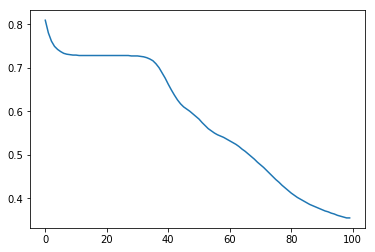

In [18]:
plt.plot(train_error)

In [19]:
test_input.size()

torch.Size([1000, 784])

In [20]:
Prediction = torch.zeros(size=(1000,10))

In [21]:
for k in range(Prediction.size(0)):
    x = test_input[k]
    _,_,_,_,x2 = forward_pass(x,w1,w2,b1,b2)
    
    Prediction[k,:] = x2

    

In [22]:
test = torch.argmax(test_target,dim=1)

In [23]:
pred = torch.argmax(Prediction,dim=1)

In [24]:
(int(sum(test==pred)) / pred.size(0)) * 100

74.5

## CNN

In [25]:
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = True, normalize = True, flatten = False)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/aims/.local/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [97]:
def train_model(model,train_input,train_target, mini_batch_size=100):
    
    train_input, train_target = Variable(train_input), Variable(train_target)

    model, criterion = Net(), nn.MSELoss()
    eta = 1e-1

    for e in range(0, 25):
        sum_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        print(e, sum_loss)

In [110]:
model= Net()
train_model(model,train_input,train_target)

0 0.9317096769809723
1 0.8004817217588425
2 0.7303637638688087
3 0.6706141084432602
4 0.6184233389794827
5 0.5737861730158329
6 0.5374620966613293
7 0.5120180286467075
8 0.5020802095532417
9 0.467223834246397
10 0.43965745344758034
11 0.4230715185403824
12 0.4242453761398792
13 0.4068593233823776
14 0.37808458134531975
15 0.3920299708843231
16 0.357477106153965
17 0.33990385197103024
18 0.3309630714356899
19 0.32369043305516243
20 0.31674420461058617
21 0.3086628057062626
22 0.2963087745010853
23 0.2845682445913553
24 0.30947767943143845


## Test error

In [111]:

def compute_nb_errors(model,test_input, test_target, mini_batch_size = 100):
     
    test_input, test_target = Variable(test_input), Variable(test_target)


    accuracy_list = []
    for t in range(0, test_input.size(0),mini_batch_size):
        output = model(test_input.narrow(0, t, mini_batch_size))
        target = test_target.narrow(0, t, mini_batch_size)
        pred = torch.tensor([int(torch.argmax(output[i])) for i in range(len(output))])

        correct = torch.tensor([int(torch.argmax(target[i])) for i in range(len(target))])

        accuracy =(((pred == correct) *1.0).mean()) * 100
        accuracy_list.append(accuracy)
        maxL = max(accuracy_list)
    print (float(accuracy),float(maxL))
            

In [112]:
compute_nb_errors(model,test_input, test_target)

12.0 16.0


# 3CNN

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64,32, kernel_size=5)
        self.fc1 = nn.Linear(, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv3(x), kernel_size=1, stride=1))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.relu(self.fc2(x.view(-1, 200)))
        x = self.fc3(x)
        return x